# Lab IV: Convolution Neural Network
***Author: Yiru Zhang***

*Department of Computer Science*

*Ecole Supérieure d'Ingénieur Léonard De Vinci*

In this lab session, you will learn to build up and apply your first convolution neural network.

Even though many new architectures have replaced the vanilla convoluntion network, the idea of CNN still play a pivotal role in Computer vision domain. Moreover, the toolboxes involved in this lab session is still hot for any AI applications.

The objective of this session is simply introduce to your basic manipulation in deep learning programming, with [PyTorch](https://pytorch.org/get-started/locally/) framework. (Some code semgents in slides are in [Keras](https://keras.io/getting_started/), but PyTorch is much more popular (and a little easier to use) today so we apply it directly.)


In this lab session. I will guide you to write a fully connected multilayer perceptron, and then give you more liberty in implementing a CNN.

You do not need to implement anything in the first model, but you need to understand every line of the model.

You should implement your CNN (LeNet5) by your own.

There are many tutorials online, and I encourage you to refer to them. The techniques involved is extremely useful (and fortunately NOT really trivial! ;-) )

## Environment setting
You need to install [`pytorch`](https://pytorch.org/) firstly, then import it.

In [58]:
import torch

As you may know, GPU is always a good equipement. So check if you have it in your setting: (You can use CPU in this lab session. The configuration of GPU and CUDA takes much time and it's not necessary for a starting session.)

In [59]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Data preparation: MNIST dataset
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.

The MNIST database contains 60,000 training images and 10,000 testing images.

PyTorch domain libraries provide a number of pre-loaded datasets, including MNIST. We can download it directly to local.

[This is the introduction (and the source) of this data](http://yann.lecun.com/exdb/mnist/)

In [60]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

You can see the information on data directly by `print(train_data)`.

Each sample is a 28 * 28 image.

Let's show some of them:

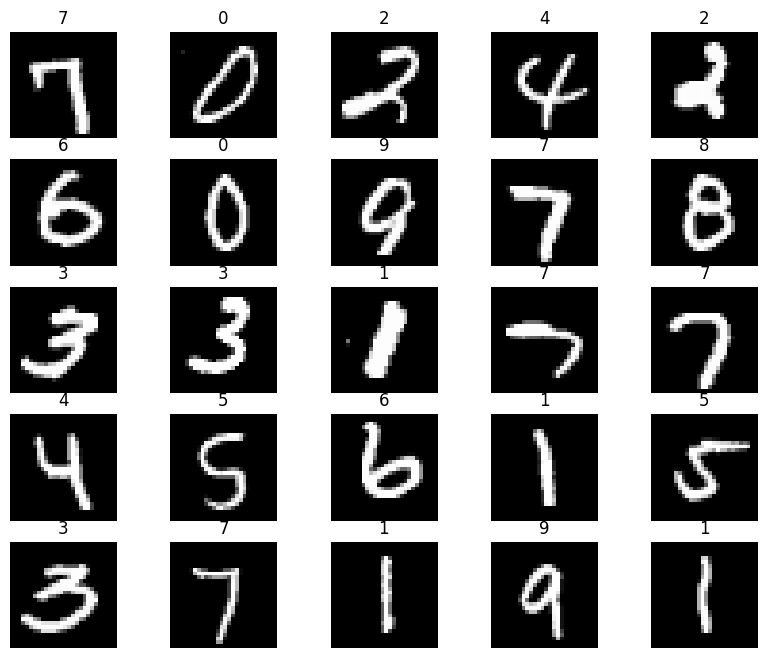

In [61]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

You can see that every image is targeted with its corresponding digit. And we have 60000 labeled data in `train_data` and 10000 in `test_data`.

In [62]:
print(train_data.data.size(), test_data.data.size())

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


Pytorch provides easy-to-use API [`DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to manage data during the training/testing process. It defines batch_size, shuffle mode, etc.

In [63]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x138942350>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x148113c90>}

<a name="simple_NN"></a>

## Build your own simple Neural Network

Now, try to build up your own Nerural Network. Let's start from the most simple one: Multi-Layer Perceptron. (Slide 11 in lecture)

Complete the model with instructions.
[`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) is the basic class for all neural network module. Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes.

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the forward method.

You can read [this page](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) for more reference.

You only need to complete the missing parts with `#TODO`

In [64]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        """
        In the initialisation function, you need to define all the layers
        involved in the architecture.

        You can either define each layer separately, or make up several components
        of multi-layer in a sequential way.

        In the example below, I show you both the two ways:
        The Flatten operation is defined separately, the input, hidden, and output layers
        are defined in a sequential way.
        """
        super().__init__()
        self.flatten = nn.Flatten()
        self.one_hidden_layer = nn.Sequential(  # define each component in a nn.Sequential
            nn.Linear(28*28, 512),              # A linear transformation y=wx + b
                                                # input dimension is 28*28 and output dimension is 512.
            nn.Tanh(),                          # The ouput of previous layer should
                                                # pass through an Tanh activation function
            nn.Linear(512, 10)                  #  Another linear transformation to logits ("logits": Slide 13)
            # What are the dimension of data in this layer? (Hint: You have 10 classes in your classification problem)
        )
    def forward(self, x):
        """
        In the forward function, you should define how data flow passes
        to each layer/sequential layers, usually already defined as attribute of this class.

        """
        x = self.flatten(x)                     # Firstly, flatten an image to a vector (use nn.Flatten())
        logits = self.one_hidden_layer(x)       # Then pass the vector into the neural network.
        return logits

Once the model is defined, you shoud load it to your device

In [65]:
model = MLP().to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (one_hidden_layer): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Training process
To train a model, we need to define following parameters:
1. Loss function: we choose [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy) as loss function. Cross entropy defines the divergence between two probability distribution (ditribution of two classes in this problem). It is usually applied in classification problems (Slide 26).
2. Optimizer: Pytorch has already integrated many [optimizers](https://pytorch.org/docs/stable/optim.html). We `SGD` is often selected by default. (Slide 31)



In [66]:
from torch import optim
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Now train your model.

In [67]:
def train():
    trainingEpoch_loss = []
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(loaders["train"], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels) # calculate the loss between the predicted output and the ground truth label.
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
                trainingEpoch_loss.append(running_loss)
                running_loss = 0.0

    print('Finished Training')
    return trainingEpoch_loss
loss_list=train()

[1,   100] loss: 210.215
[1,   200] loss: 166.023
[1,   300] loss: 128.247
[1,   400] loss: 103.065
[1,   500] loss: 86.623
[1,   600] loss: 75.619
[2,   100] loss: 68.370
[2,   200] loss: 62.797
[2,   300] loss: 58.386
[2,   400] loss: 54.834
[2,   500] loss: 52.286
[2,   600] loss: 52.224
Finished Training


Let's plot the loss curve. You can clearly see that the loss converges, which is always a good sign.

<function matplotlib.pyplot.show(close=None, block=None)>

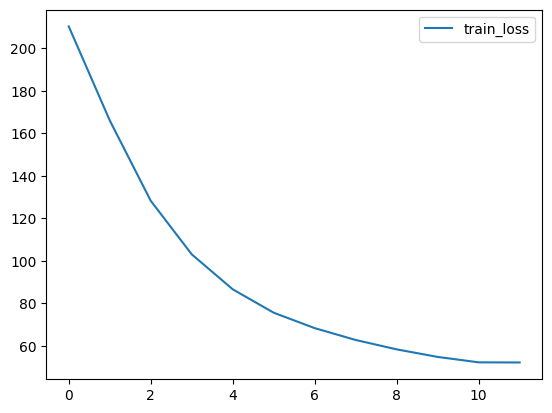

In [68]:
plt.plot(loss_list, label='train_loss')

plt.legend()
plt.show

Then, evaluate this model on the trained model:

In [69]:
def test():
    # Test the model
    model.eval()            # Set the model on evaluation model
    with torch.no_grad():   # We do not want the gradient to desend anymore during the evaluation process.
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

    pass
test()

Test Accuracy of the model on the 10000 test images: 0.83


The accuracy is around 92%, which is somewhat not bad. This is because the dataset we use is simple. If you try the more chanllenging tasks (such as [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) ), the results would be propabably worse. If you are interested, you can also download this dataset easily with `torchvision`. A more detailed tuto is available [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

## Build your Convoluntion Neural Network
As you have learned, Convolution layers are suitable for Vision missions. To recall, below is the architecture of LeNet5.
<img src="https://d2l.ai/_images/lenet.svg" alt="LeNet architecture" />

LeNet5 has 5 layers with two convolutional and three fully connected layers. Read the following detailed introduction and implement your own LeNet5.



#### 1. First layer: Covolution (C1)
 The first layer is a 2-D convolution layer ([`nn.Conv2D`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)). It accepts as input a **greyscale** (`in_channels = 1`) image of 28x28, indicating that the architecture is not suitable for RGB images. It consists of 6 convolution filters (**kernels**) of size 5x5  (`kernel_size = 5`) . Each kernel, representing a specific form in a 5x5 matrix, output to a feature map after convolution operation. Therefore, there will be 6 output chanels (`out_channels = 6`).  

Essentially, LeCun assumes and implies that 6 different basic forms are needed to recognize the digit in the manuscript, while each form needs to be represented by a matrix of 5x5.

You should also set Padding and Strides (See Slide 44, 45). Defining the way that kernels scan on the input image. You can set Strides to 1 and Padding to 0, usually applied as default values (`stride=1`, `padding=0`).

The size of output will change after this process, depending on the size of kernel, Padding, and Strides (Slide 46).

You should also apply activation function (ReLU, Tanh, Sigmoid, etc.) on the output of the convolution layer by `nn.ReLU`. The purpose is to add non-linearity to the operation. (The convolution and matrix manipulations involved are all linear operations. You cannot say that digit recgonition is a linear task, can you? [Here is a more detailed explaination](https://medium.com/@nerdjock/convolutional-neural-network-lesson-9-activation-functions-in-cnns-57def9c6e759))

#### 2. Pooling (S2)

The output would be 28x28x6. After this, pooling is applied to decrease the feature map by half, i.e, 14x14x6. (Slide 47) We take the maximum of every 2x2 pixels. [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d). For its parameters, we should set `kernel_size` by `2` because we take maximum in the range of 2x2. We should also set `stride` by `2` because we do not want to overlap the range when pooling.  

#### 3. Convolution (C3)
The output of previous pooling pass to the second convolution layer as input. You already know the meaning of each parameters. I resume here:
* 6 channels as input, while 16 channels as output (because LeCun assumed that 16 kernels help best to extract the appropriate forms.)
* kernel size is still 5x5 (to represent a form)
* Still we take stride and padding by default value (stride=1, padding=0)

Then, don't forget to add non-linearity by activation function `nn.ReLU()`.

#### 4. Pooling (S4)
Followed by the second convolution layer, we sample the features by another pooling layer. We can apply the same pooling layer in S2. Again, the output size is automatically calculated by equation in Slide 46.

The output of S4 is therefore the features we extract by convolution operations.


#### 5.6.7 Fully connected layers (F5 full, F6 full, Out)

The features are in a tensor of 16x5x5. You need to reshape it then pass to the classifier (equal to a flatten procedure. you can use `out = reshape(out.size(0), -1)` in the `forward(self,x)` method, where `out` denotes your dataflow).

The layers after are as simple as "your first Neural Network" introduced at the begining of this lab session.
You need to be careful on their dimensions. You have 120 perceptrons in F5, 84 in F6, and 10 in Out layer (because you have 10 classes).
Don't forget to apply activation function on the output of each fully connected layer.


Now follow the comments in the code and complete the model.

A tutorial (but not LeNet5) is available [HERE](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

In [70]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # C1 Convolutional Layer
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # S2 Pooling Layer
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # C3 Convolutional Layer
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        # S4 Pooling Layer
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # F5 Fully Connected Layer
        self.f5 = nn.Linear(16 * 4 * 4, 120) 
        self.relu5 = nn.ReLU()
        # F6 Fully Connected Layer
        self.f6 = nn.Linear(120, 84)
        self.relu6 = nn.ReLU()
        # Output Layer
        self.out = nn.Linear(84, 10)

    def forward(self, x):
        # First Convolution and Pooling
        x = self.relu1(self.c1(x))
        x = self.s2(x)
        # Second Convolution and Pooling
        x = self.relu3(self.c3(x))
        x = self.s4(x)
        # Flattening the output for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.relu5(self.f5(x))
        x = self.relu6(self.f6(x))
        x = self.out(x)
        return x


LeNet(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU()
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (f5): Linear(in_features=256, out_features=120, bias=True)
  (relu5): ReLU()
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (relu6): ReLU()
  (out): Linear(in_features=84, out_features=10, bias=True)
)
[1,   100] loss: 230.569
[1,   200] loss: 230.010
[1,   300] loss: 229.670
[1,   400] loss: 229.194
[1,   500] loss: 228.473
[1,   600] loss: 227.335
[2,   100] loss: 225.303
[2,   200] loss: 220.235
[2,   300] loss: 203.865
[2,   400] loss: 157.206
[2,   500] loss: 99.191
[2,   600] loss: 67.789
Finished Training


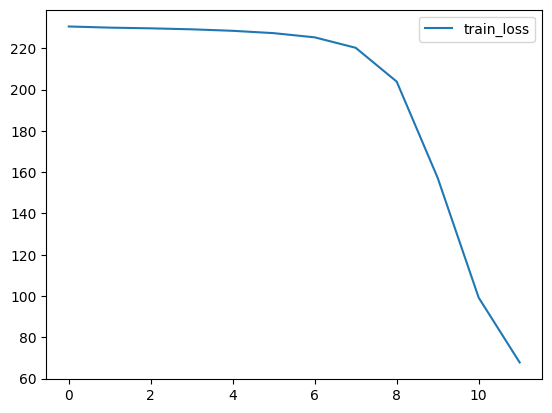

Test Accuracy of the model on the 10000 test images: 0.81


In [71]:
model = LeNet().to(device)  # Initialize your LeNet model and move it to the appropriate device
print(model)

loss_func = nn.CrossEntropyLoss()  # Define the loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Define the optimizer

# Train the model
loss_list = train()

# Plot the loss curve
plt.plot(loss_list, label='train_loss')
plt.legend()
plt.show()

# Test the model
test()


### Train and test your LeNet5

You should define the loss function and optimization method, the train your LeNet5
You can reuse the training and testing code as in "[Your simple neural network](#simple_NN)"

What's your accuracy this time?
I get at best 81% accuracy.  